In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.0 MB/s eta 0:00:00
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-6tkhfh6l
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-6tkhfh6l
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.28 which is incompatible.

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 25.37 MiB/s, done.


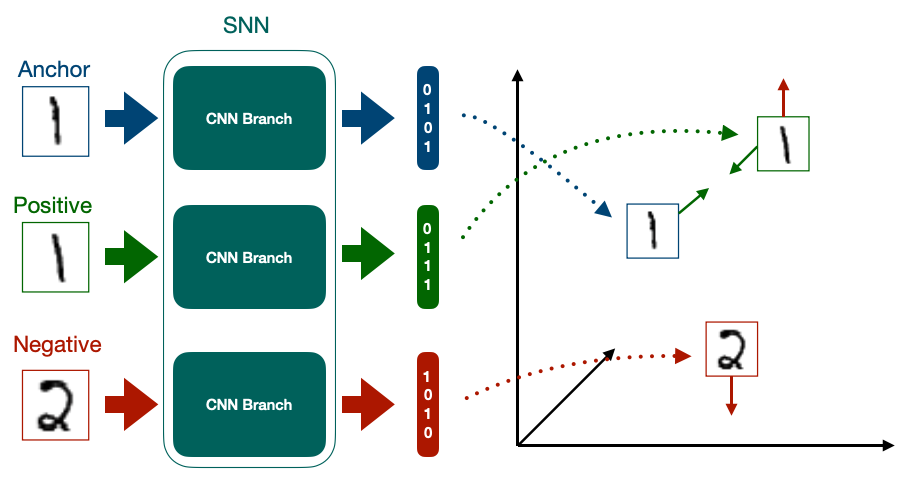

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [5]:
DATA_DIR= '/content/Person-Re-Id-Dataset/train'
CSV_FILE='/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE=32
LR=0.001
EPOCHS=15

DEVICE='cuda'

In [6]:
df=pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [12]:
import os

row=df.iloc[5]

A_img=io.imread(os.path.join(DATA_DIR, row.Anchor))
P_img=io.imread(os.path.join(DATA_DIR, row.Positive))
N_img=io.imread(os.path.join(DATA_DIR, row.Negative))


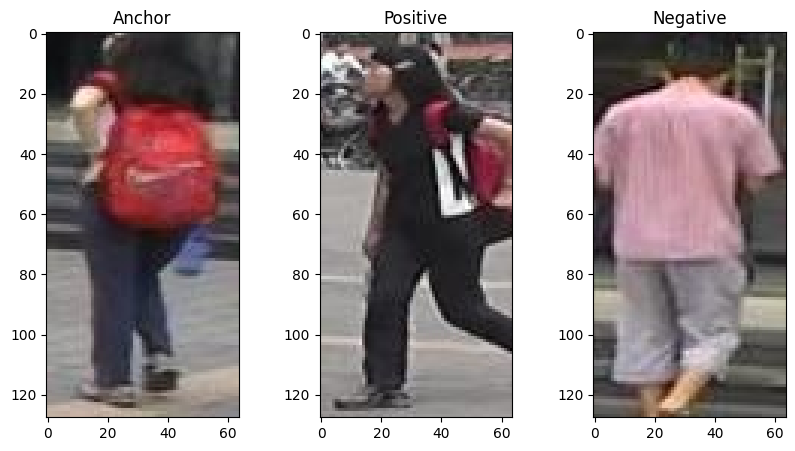

In [13]:
f ,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [14]:
train_df,valid_df=train_test_split(df, test_size=0.2, random_state=42)

# Create APN Dataset

In [16]:
class APN_Dataset(Dataset):
  def __init__(self,df):
    self.df=df

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    A_img=io.imread(os.path.join(DATA_DIR, row.Anchor))
    P_img=io.imread(os.path.join(DATA_DIR, row.Positive))
    N_img=io.imread(os.path.join(DATA_DIR, row.Negative))

    A_img=torch.tensor(A_img).permute(2,0,1)/255.0
    P_img=torch.tensor(P_img).permute(2,0,1)/255.0
    N_img=torch.tensor(N_img).permute(2,0,1)/255.0
    return A_img,P_img,N_img

In [17]:
trainset=APN_Dataset(train_df)
validset=APN_Dataset(valid_df)

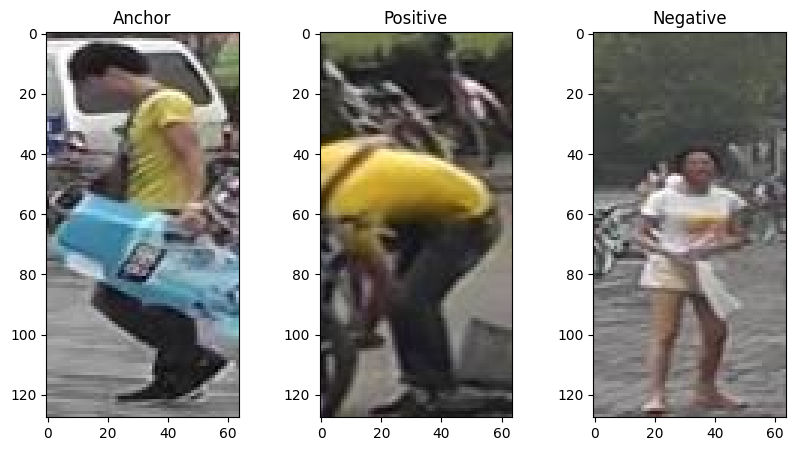

In [18]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [21]:
trainloader=DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader=DataLoader(validset, batch_size=BATCH_SIZE)

In [22]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [23]:
for A,P,N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [25]:
class APN_Model(nn.Module):
  def __init__(self, emb_size=512):
    super(APN_Model, self).__init__()
    self.efficientnet=timm.create_model('efficientnet_b0', pretrained=True)
    self.efficientnet.classifier=nn.Identity(in_features=self.efficientnet.classifier.in_features,out_features=emb_size)

  def forward(self, images):
    embeddings=self.efficientnet(images)
    return embeddings

In [26]:
model=APN_Model()
model.to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw):

# Create Train and Eval function

In [27]:
def train_fn(model, data_loader, optimizer,criterion):
  model.train()
  total_loss=0.0

  for A,P,N in tqdm(data_loader):
    A,P,N=A.to(DEVICE),P.to(DEVICE),N.to(DEVICE)

    A_embs=model(A)
    P_embs=model(P)
    N_embs=model(N)

    loss=criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(data_loader)



In [28]:
def eval_fn(model, data_loader,criterion):
  model.eval()
  total_loss=0.0
  with torch.no_grad():
    for A,P,N in tqdm(data_loader):
      A,P,N=A.to(DEVICE),P.to(DEVICE),N.to(DEVICE)

      A_embs=model(A)
      P_embs=model(P)
      N_embs=model(N)

      loss=criterion(A_embs, P_embs, N_embs)

      total_loss+=loss.item()

    return total_loss/len(data_loader)

In [29]:
criterion=nn.TripletMarginLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=LR)

# Create Training Loop

In [30]:
best_valid_loss=np.inf
for epoch in range(EPOCHS):
  train_loss=train_fn(model, trainloader, optimizer,criterion)
  valid_loss=eval_fn(model,validloader,criterion)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss=valid_loss

  print(f'EPOCHS:{epoch+1} train_loss:{train_loss} valid_loss:{valid_loss}')


100%|██████████| 25/25 [00:02<00:00,  9.03it/s]


EPOCHS:1 train_loss:0.6920995816588402 valid_loss:0.2752379417419434


100%|██████████| 25/25 [00:02<00:00,  8.47it/s]


EPOCHS:2 train_loss:0.1247146886587143 valid_loss:0.17790208220481873


100%|██████████| 25/25 [00:02<00:00,  9.52it/s]


EPOCHS:3 train_loss:0.06967180669307708 valid_loss:0.16097644448280335


100%|██████████| 25/25 [00:02<00:00,  9.62it/s]


EPOCHS:4 train_loss:0.034800837934017184 valid_loss:0.1316629481315613


100%|██████████| 25/25 [00:02<00:00,  9.41it/s]


EPOCHS:5 train_loss:0.033750794529914856 valid_loss:0.1455983543395996


100%|██████████| 25/25 [00:02<00:00,  9.71it/s]


EPOCHS:6 train_loss:0.043419505804777145 valid_loss:0.15582998156547545


100%|██████████| 25/25 [00:02<00:00,  9.60it/s]


EPOCHS:7 train_loss:0.03953184336423874 valid_loss:0.1568362283706665


100%|██████████| 25/25 [00:02<00:00,  9.78it/s]


EPOCHS:8 train_loss:0.0448593769967556 valid_loss:0.15913490176200867


100%|██████████| 25/25 [00:02<00:00,  9.40it/s]


EPOCHS:9 train_loss:0.04668803229928017 valid_loss:0.12829282402992248


100%|██████████| 25/25 [00:02<00:00,  9.54it/s]


EPOCHS:10 train_loss:0.03218028143048286 valid_loss:0.18665580987930297


100%|██████████| 25/25 [00:02<00:00,  9.74it/s]


EPOCHS:11 train_loss:0.03193202137947083 valid_loss:0.1505517828464508


100%|██████████| 25/25 [00:03<00:00,  8.24it/s]


EPOCHS:12 train_loss:0.024279349595308305 valid_loss:0.09223377704620361


100%|██████████| 25/25 [00:03<00:00,  7.65it/s]


EPOCHS:13 train_loss:0.013795611560344695 valid_loss:0.10063282012939453


100%|██████████| 25/25 [00:03<00:00,  8.33it/s]


EPOCHS:14 train_loss:0.02394226461648941 valid_loss:0.13296968698501588


100%|██████████| 25/25 [00:02<00:00,  9.64it/s]

EPOCHS:15 train_loss:0.020586802065372466 valid_loss:0.09097614586353302


# Get Anchor Embeddings

In [48]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names=pd.Series(anc_img_names) # Convert to pandas Series
  encodings=[]
  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names):
      A=io.imread(os.path.join(DATA_DIR, i))
      A=torch.tensor(A).permute(2,0,1)/255.0
      A=A.to(DEVICE)
      A_enc=model(A.unsqueeze(0))
      # Fix: Squeeze the (1, 1280) array to (1280,) before appending
      encodings.append(A_enc.cpu().detach().numpy().squeeze(0))

    encodings=np.array(encodings)
    encodings=pd.DataFrame(encodings)
    df_enc=pd.concat([anc_img_names, encodings], axis=1)

  return df_enc

In [49]:
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [50]:
df_enc=get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:58<00:00, 68.87it/s]


In [51]:
df_enc.to_csv('database.csv',index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,1420_c5s3_052165_01.jpg,-0.196707,0.204359,-0.201228,0.494226,0.837386,-0.154698,-0.054426,0.643980,0.032094,...,0.534941,0.876583,1.975163,0.306327,-0.221771,0.496339,0.331483,1.187366,-0.145256,-0.089553
1,1420_c3s3_061978_03.jpg,-0.186983,0.244098,-0.181223,0.986367,0.477033,-0.134676,-0.068665,0.594436,0.049586,...,0.391181,0.709786,0.700146,0.264888,-0.194861,0.243743,0.234866,2.081035,-0.101999,0.108523
2,1420_c5s3_062565_05.jpg,-0.203907,0.536405,-0.114230,0.606890,0.367920,-0.146079,-0.099140,0.428074,0.258564,...,0.404932,0.794558,1.928032,-0.007406,-0.250544,0.774501,0.928487,1.358215,-0.031275,-0.002989
3,1420_c6s3_085592_04.jpg,-0.161864,0.104428,-0.212221,0.598729,1.021732,-0.182043,-0.109798,0.385411,-0.056612,...,0.323088,0.739092,1.183713,0.074800,-0.181768,0.459260,0.280155,1.158858,-0.172354,0.020554
4,0663_c5s3_085987_03.jpg,0.863723,-0.096040,-0.127708,-0.100548,-0.083694,1.096868,0.464750,-0.102270,-0.125758,...,-0.135660,-0.109915,0.350368,-0.026131,-0.175164,0.143425,0.365050,-0.073716,0.033099,0.374706


# Inference

In [52]:
def euclidean_dist(img_enc,anc_enc_arr):
  dist=np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
  return dist

In [54]:
idx=0
img_name=df_enc['Anchor'].iloc[idx]
img_path=os.path.join(DATA_DIR, img_name)
img=io.imread(img_path)
img=torch.tensor(img).permute(2,0,1)/255.0
model.eval()
with torch.no_grad():
  img=img.to(DEVICE)
  img_enc=model(img.unsqueeze(0))
  img_enc=img_enc.detach().cpu().numpy()


In [56]:
anc_enc_arr=df_enc.iloc[:,1:].to_numpy()
anc_img_names=df_enc['Anchor']

In [57]:
distance=[]
for  i in range(anc_enc_arr.shape[0]):
  dist=euclidean_dist(img_enc,anc_enc_arr[i:i+1,:])
  distance.append(dist)

In [58]:
closest_idx=np.argsort(distance)

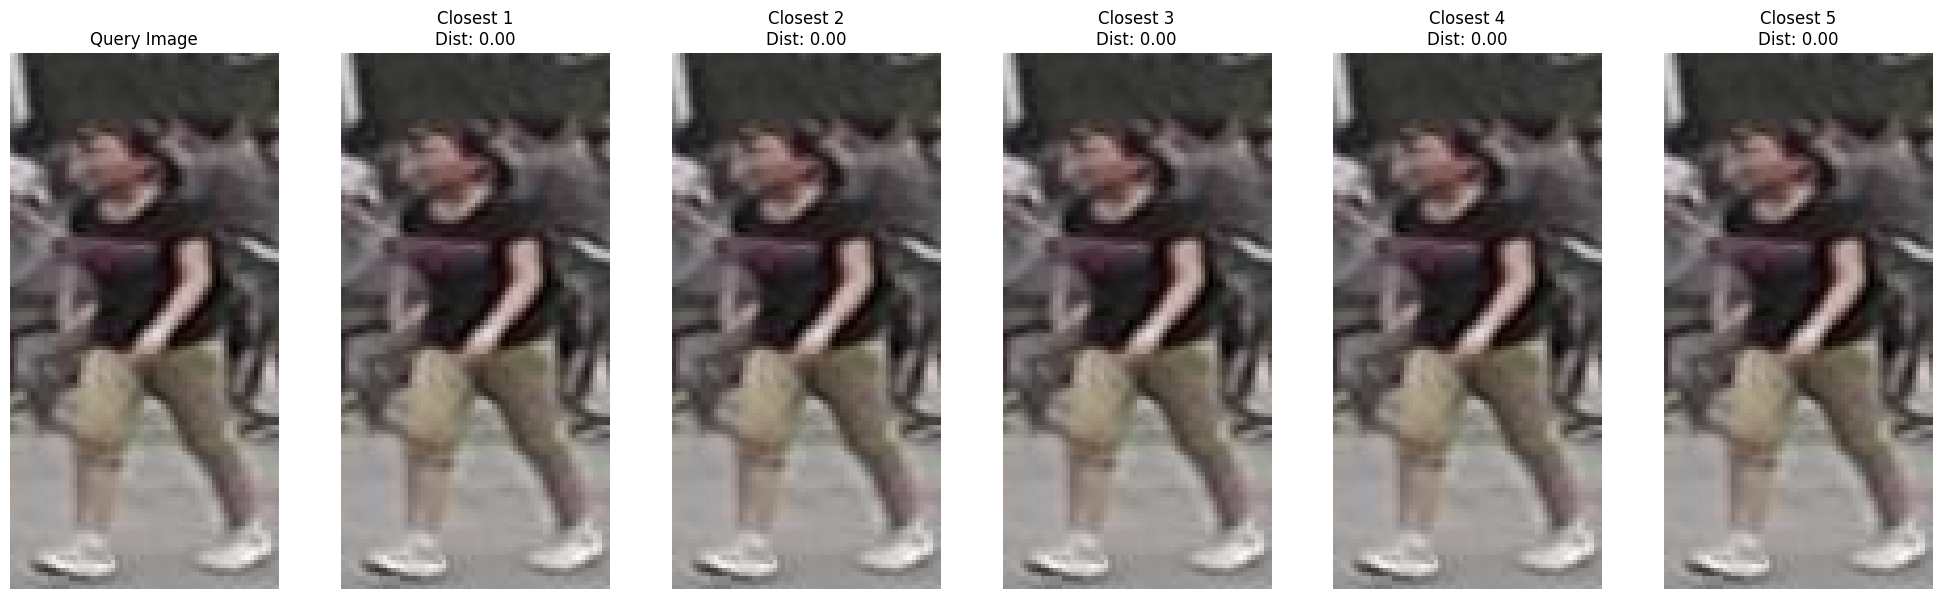

In [66]:
import matplotlib.pyplot as plt
import os
from skimage import io
import numpy as np

def plot_closest_imgs(anc_img_names, DATA_DIR, image, img_path, closest_idx, distance, no_of_closest = 5):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, no_of_closest + 1, 1)
    plt.imshow(image.cpu().numpy().transpose((1,2,0))) # Fixed: Added .cpu()
    plt.title("Query Image")
    plt.axis('off')

    S_name = []
    for s in range(no_of_closest):
        # Fix: Extract the scalar index using .item()
        S_name.append(anc_img_names.iloc[closest_idx[s].item()])

    for i in range(len(S_name)):
        closest_img_name = S_name[i]
        closest_img_path = os.path.join(DATA_DIR, closest_img_name)
        closest_img = io.imread(closest_img_path)

        plt.subplot(1, no_of_closest + 1, i + 2)
        plt.imshow(closest_img)
        # Fix: Extract the scalar distance using .item()
        plt.title(f"Closest {i+1}\nDist: {distance[closest_idx[i].item()].item():.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);